In [1]:
#imports to create a fedot model

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
logging.raiseExceptions = False

import fedot
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import TsForecastingParams, Task, TaskTypesEnum
from fedot.core.utils import fedot_project_root

In [2]:
#datasets
datasets = {
    'australia': f'{fedot_project_root()}/examples/data/ts/australia.csv',
    'beer': f'{fedot_project_root()}/examples/data/ts/beer.csv',
    'salaries': f'{fedot_project_root()}/examples/data/ts/salaries.csv',
    'stackoverflow': f'{fedot_project_root()}/examples/data/ts/stackoverflow.csv'}

2022-10-13 14:35:35.037922: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Generations:   1%|          | 1/100 [01:09<?, ?gen/s]

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

 38%|███▊      | 384/1000 [00:49<01:18,  7.82trial/s, best loss: 1.0157974938289935]


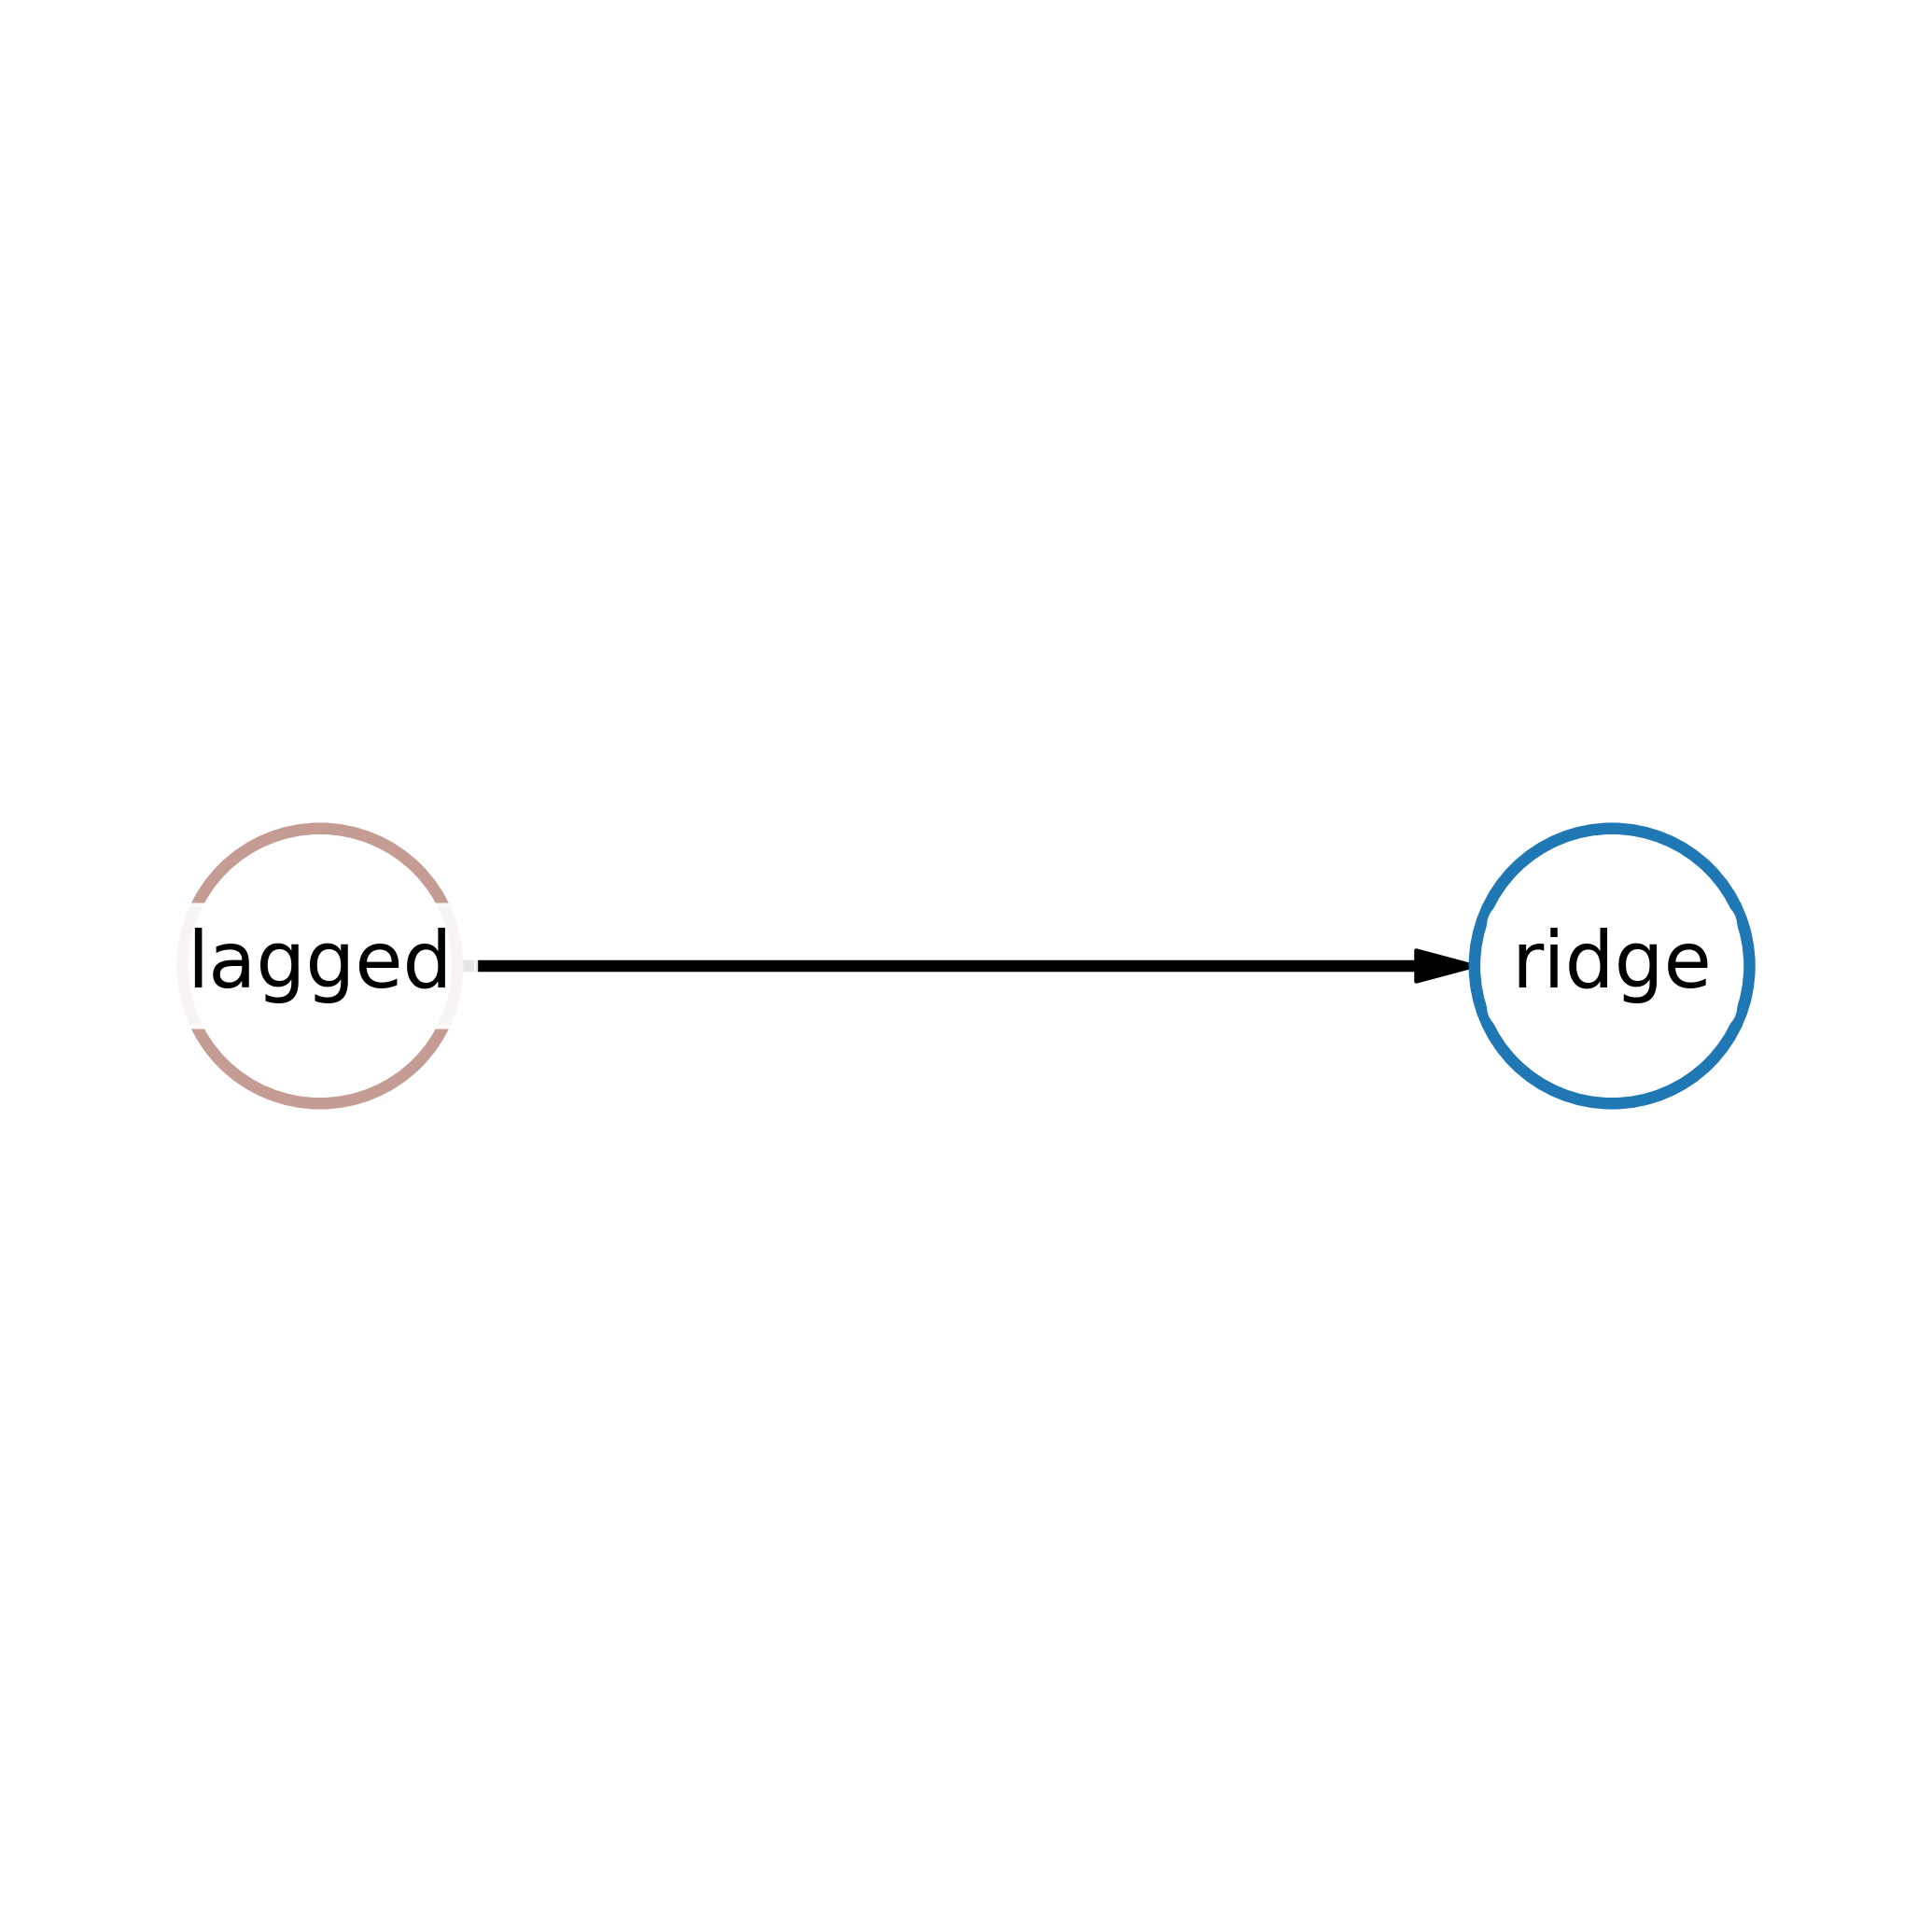

{'rmse': 6.390692153456042, 'mae': 4.919543574868154, 'mape': 0.25496674172720346}


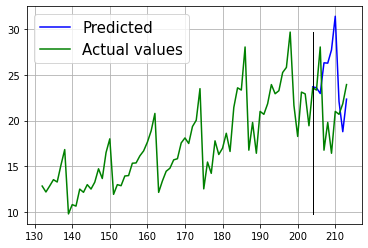

In [3]:
#initialize a fedot model

#time_series = pd.read_csv('AirPassengers.csv')
dataset='australia'
horizon = 10
validation_blocks = 2
time_series = pd.read_csv(datasets[dataset])

task = Task(TaskTypesEnum.ts_forecasting,  TsForecastingParams(forecast_length=horizon))
if dataset not in ['australia']:
    idx = pd.to_datetime(time_series['idx'].values)
else:
    idx = time_series['idx'].values
#idx =  time_series['Month'].values
time_series = time_series['value'].values
#time_series = time_series['#Passengers'].values
train_input = InputData(idx=idx,
                            features=time_series,
                            target=time_series,
                            task=task,
                            data_type=DataTypesEnum.ts)
train_data, test_data = train_test_data_setup(train_input, validation_blocks=2)

# init model for the time series forecasting
model = Fedot(problem='ts_forecasting',
                  task_params=task.task_params,
                  timeout=2,
                  n_jobs=1,
                  cv_folds=2, validation_blocks=2, preset='fast_train')

# run AutoML model design in the same way
pipeline = model.fit(train_data)
pipeline.show()

# use model to obtain forecast
forecast = model.predict(test_data)
target = np.ravel(test_data.target)
print(model.get_metrics(metric_names=['rmse', 'mae', 'mape'], target=target))
model.plot_prediction()
#model.plot_prediction() works incorrectly

In [4]:
#importing for tuning
from fedot.core.optimisers.adapters import PipelineAdapter
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum
from fedot.core.pipelines.tuning.tuner_interface import HyperoptTuner
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.optimisers.composer_requirements import ComposerRequirements
import datetime

from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum

#these parameters are the same for both tuners below
task = Task(TaskTypesEnum.ts_forecasting,TsForecastingParams(forecast_length=horizon))
composer_requirements = ComposerRequirements()
composer_requirements.validation_blocks = 2
composer_requirements.n_jobs= -1
composer_requirements.show_progress = True

#this tuner will be used to create lower confidence interval
low_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(RegressionMetricsEnum('quantile_loss_1')) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

#this tuner will be used to create uppper confidence interval
up_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(RegressionMetricsEnum('quantile_loss_9')) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

In [5]:
#the function below takes as input a lists of np.arrays and returns 
# an array of upper quantiles and an array of lower quantiles

def f(quantile,arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    up = []
    low = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        q_up = np.quantile(x, 1-quantile)
        up.append(q_up)
        q_low = np.quantile(x,quantile)
        low.append(q_low)
    up = np.array(up)
    low = np.array(low)
    return {'up':up,'low':low}

#The code below shows that this function works correctly

#arrays=[]
#for i in range(25):
#    arrays.append(np.random.normal(size = 1000))
#up = f(quantile = 0.1, arrays=arrays)['up']
#low = f(quantile = 0.1, arrays = arrays)['low']
#fig,ax = plt.subplots()
#for i in range(25):
#    ax.plot(range(1000),arrays[i],color= 'blue')
#ax.plot(range(1000),up,color = 'red')
#ax.plot(range(1000),low,color = 'green');

In [7]:
ts = np.array(pd.read_csv(datasets[dataset])['value'])

In [25]:
#this is the main function in our approach
def conf_int_maker(model = model,
                   test_data = test_data,
                   series = ts,
                   number_models = 10, 
                   plot = True):
    """
    model - a fedot model of interest
    test_data - test data of the model
    series - full series of data
    number_models - number of models used to create the confidence intervals
    plot - boolean parameter indicating wheter to show plot
    """
    
    horizon = model.params.task.task_params.forecast_length
    ts = series[:-horizon]
    train_data = model.train_data
    forecast = model.predict(test_data)

    #3 lines below allow us take the best models
    fits = []
    for ind in model.history.individuals[-1]:
        fits.append(ind.fitness.value)
    fits = np.sort(np.array(fits))

    #create up and low predictions
    up_predictions = []
    low_predictions = []
    
    for ind in model.history.individuals[-1]:
        if ind.fitness.value<=fits[number_models]:
            pipeline = PipelineAdapter().restore(ind.graph)
            
            #tuning upper confidence interval
            tuned_pipeline = up_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            up_predictions.append(preds)
            
            #tuning lower confidence interval
            tuned_pipeline = low_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            low_predictions.append(preds)
         
    # upper interval
    up_res= f(quantile = 0.1, arrays = up_predictions)
    up = np.maximum(up_res['up'],forecast)

    # lower interval
    low_res= f(quantile = 0.1, arrays = low_predictions)
    low = np.minimum(low_res['low'],forecast)
  
    if plot:
        fig,ax = plt.subplots()
        fig.set(figwidth = 15,figheight = 7)
        for i in range(len(up_predictions)):
            if i==0:
                ax.plot(up_predictions[i], color = 'yellow',label = 'preds for up train')
                ax.plot(low_predictions[i], color = 'pink',label = 'preds for up train')
            else:
                ax.plot(up_predictions[i], color = 'yellow')
                ax.plot(low_predictions[i], color = 'pink')    
        ax.plot(up, color = 'red', label  = 'Up',marker= '.')
        ax.plot(low, color = 'green', label  = 'Low',marker = '.')
        ax.plot(forecast, color = 'blue', label = 'Forecast')
        ax.plot(ts[-horizon:],color = 'black', label = 'Actual TS')
        plt.legend()
    ans = {'up':up,'low':low}
    
    return ans

100%|██████████| 10/10 [00:03<00:00,  2.91trial/s, best loss: 0.2787389064809246]


{'up': array([23.84139216, 24.77720148, 24.25728911, 26.75886187, 27.02560737,
        29.81549609, 36.14474296, 27.5288417 , 27.72913326, 25.33229895]),
 'low': array([12.9383369 , 12.17942982, 12.70548212, 14.55914779, 15.56942387,
        17.79249897, 21.0392936 , 19.34027755, 18.7839192 , 15.09217142])}

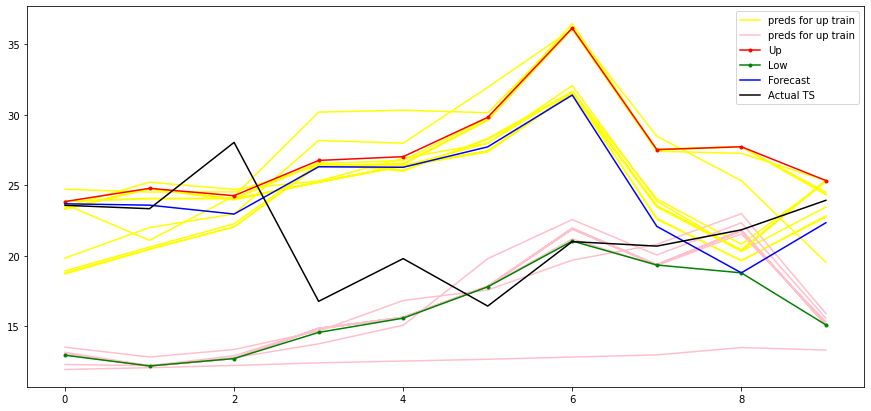

In [23]:
conf_int_maker(model = model, plot = True)